# Non-Parallel Classifiers

In this section I implement and evaluate the same classifiers that we used with PySpark, but with an ordinary non-parallel implementation (sklearn is used here, without parallelisation for those classifiers which support it). I then compare the results obtained to the parallel version, and discuss potential reasons for the differences.

The dataset used here is a set of sequences of API calls from 42797 malware and 1079 benign programs. Each sequence consists of the first 100 API calls made by the corresponding program (obtained by observing it dynamically), not counting immediate repetitions. Each different type of call is represented as a different integer.

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, make_scorer

Here we read the data into a table, and drop the column which contains MD5 hashes of the programs since this is of no use to us.

In [2]:
df = pd.read_csv("../data/dynamic_api_call_sequence_per_malware_100_0_306.csv")
df.drop('hash', axis=1, inplace=True)
df

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,112,274,158,215,274,158,215,298,76,208,...,71,297,135,171,215,35,208,56,71,1
1,82,208,187,208,172,117,172,117,172,117,...,81,240,117,71,297,135,171,215,35,1
2,16,110,240,117,240,117,240,117,240,117,...,65,112,123,65,112,123,65,113,112,1
3,82,208,187,208,172,117,172,117,172,117,...,208,302,208,302,187,208,302,228,302,1
4,82,240,117,240,117,240,117,240,117,172,...,209,260,40,209,260,141,260,141,260,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43871,82,240,117,240,117,240,117,240,117,172,...,141,260,141,260,141,260,141,260,141,1
43872,82,240,117,240,117,240,117,240,117,172,...,159,224,82,159,224,82,159,224,82,1
43873,82,240,117,240,117,240,117,240,117,172,...,260,141,260,141,260,141,260,141,260,1
43874,82,240,117,240,117,240,117,240,117,172,...,141,260,141,260,141,260,141,260,141,1


Here we perform one-hot encoding on the data to prepare it for use in our various classifiers, then split it into test and training data sets.

In [3]:
arr = np.array(df)
data = arr[:, 0:-1]
bad = arr[:, -1]

enc = OneHotEncoder()
oh_data = enc.fit_transform(data)

train_data, test_data, train_classes, test_classes = train_test_split(oh_data, bad, test_size=0.2, random_state=666)

The first classifier we implement is Logistic Regression. The hyperparameters are chosen to match those used in PySpark, with the exception of the maximum number of iterations (1000 iterations were needed to get convergence). In particular, the regularisation parameter C is set to a very high value which has the effect of disabling regularisation.

Logistic Regression AUC Score: 0.9317225973492961


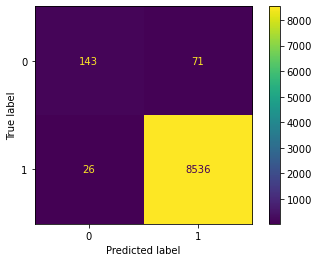

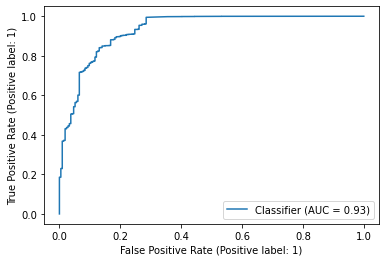

In [37]:
LR = LogisticRegression(n_jobs=1, max_iter=1000, tol=10**-6, C=1000000000)
LR.fit(train_data, train_classes)

pred = LR.predict(test_data)
decision = LR.decision_function(test_data)
ConfusionMatrixDisplay.from_predictions(test_classes, pred)
RocCurveDisplay.from_predictions(test_classes, decision)
print("Logistic Regression AUC Score:", roc_auc_score(test_classes, decision))

We see that the sklearn implementation performs significantly better under the AUC metric than the PySpark implementation did. The performance is still not very good, though - in particular the rate of false positives is very high (though this is likely at least in part due to the lack of regularisation, and also due to the training data being very imbalanced).

The next classifier we implement is a Decision Tree:

Decision Tree AUC Score: 0.7701176902068911


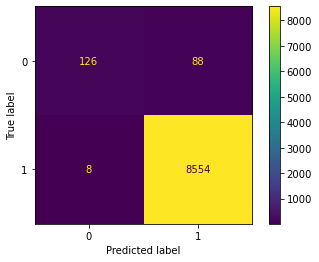

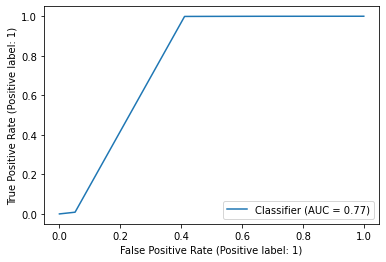

In [28]:
DT = DecisionTreeClassifier(max_depth=10, random_state=42)
DT.fit(train_data, train_classes)

pred = DT.predict(test_data)
proba = DT.predict_proba(test_data)
ConfusionMatrixDisplay.from_predictions(test_classes, pred)
RocCurveDisplay.from_predictions(test_classes, proba[:, 1])
print("Decision Tree AUC Score:", roc_auc_score(test_classes, proba[:, 1]))

We again see that the sklearn implementation performs significantly better, although by no means does it perform *well* (not that we should expect good performance from a single decision tree).

The next classifier is a Random Forest. Again, hyperparameters are chosen to match the PySpark implementation as closely as possible.

Random Forest AUC Score: 0.8912544453104021


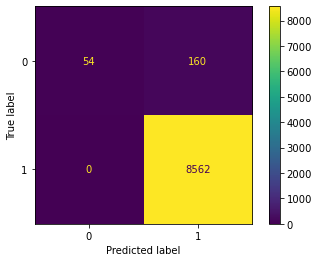

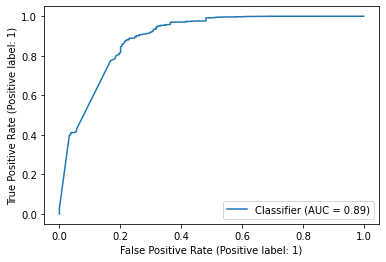

In [33]:
RF = RandomForestClassifier(n_jobs=1, random_state=42, n_estimators=20, max_depth=5)
RF.fit(train_data, train_classes)

pred = RF.predict(test_data)
proba = RF.predict_proba(test_data)
ConfusionMatrixDisplay.from_predictions(test_classes, pred)
RocCurveDisplay.from_predictions(test_classes, proba[:, 1])
print("Random Forest AUC Score:", roc_auc_score(test_classes, proba[:, 1]))

This time we see that the sklearn implementation performs just as poorly as PySpark did, obtaining a very similar AUC score. This poor performance is likely due to the maximum tree depth being very low (which is a necessary sacrifice in the massively parallel situations for which Spark is designed).

The final classifier implemented is gradient-boosted decision trees.

Gradient-Boosted Trees Score: 0.8210875810743844


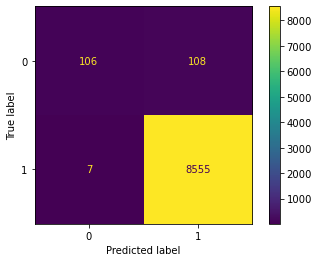

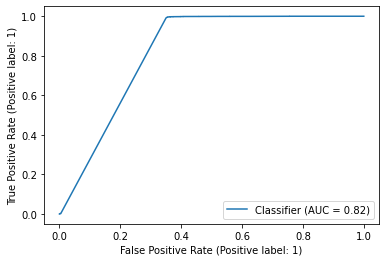

In [38]:
GB = GradientBoostingClassifier(random_state=42, n_estimators=10, max_depth=5)
GB.fit(train_data, train_classes)

pred = GB.predict(test_data)
proba = GB.predict_proba(test_data)
ConfusionMatrixDisplay.from_predictions(test_classes, pred)
RocCurveDisplay.from_predictions(test_classes, proba[:, 1])
print("Gradient-Boosted Trees Score:", roc_auc_score(test_classes, proba[:, 1]))

Again we see that the sklearn implementation has similar poor performance to the PySpark implementation, though this time it performs slightly worse rather than slightly better.

Overall, none of these classifiers have performed particularly well. However, we have generally seen the sklearn implementations outperform their PySpark counterparts (on the AUC metric) with the only exception being by a fairly small margin.

There is also another form of performance we care about here: speed. Initially we had planned to measure the precise runtime of each classifier on both implementations, but this was quickly seen to be unnecessary - in each case, the sklearn implementations run in a matter of seconds while the PySpark implementations take minutes, a difference of about 2 orders of magnitude. This is likely due to the fact Spark incurs a large amount of overhead, and for our relatively small data set this dominates the runtime.

We now use cross-validation for hyperparameter selection, in much the same way that we did with PySpark. The case for logistic regression is omitted, as the hyperparameter optimisation procedure Chentian used with PySpark relies on specific properties of that implementation and would therefore be pointless to reproduce here. In each case, the same candidate hyperparameter values as in the PySpark section are used.

Thus we start with the Decision Tree:

Cross-Validated Decision Tree AUC Score: 0.7769330141660499
Selected max depth: 30


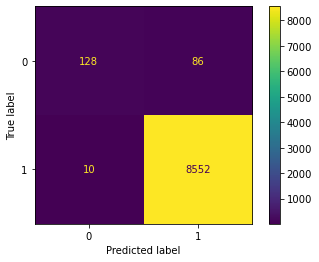

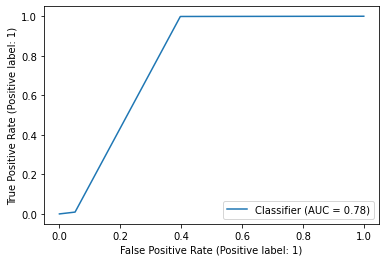

In [54]:
param_grid = {'max_depth': [2, 5, 10, 20, 30]} #The maxBins parameter in PySpark has no equivalent here
DT_CV = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring=make_scorer(roc_auc_score, needs_proba=True))
DT_CV.fit(train_data, train_classes)

pred = DT_CV.predict(test_data)
proba = DT_CV.predict_proba(test_data)
ConfusionMatrixDisplay.from_predictions(test_classes, pred)
RocCurveDisplay.from_predictions(test_classes, proba[:, 1])
print("Cross-Validated Decision Tree AUC Score:", roc_auc_score(test_classes, proba[:, 1]))
print("Selected max depth:", DT_CV.best_params_['max_depth'])

We see that the greatest of the maximum depth options presented was chosen. The result is only very slightly better than what we already had (in PySpark, the cross-validation step had a much greater impact but the end result was still much worse than this).

We now move on to the Random Forest:

Cross-Validated Random Forest AUC Score: 0.9514413284519513
Selected max depth: 10
Selected number of estimators: 50


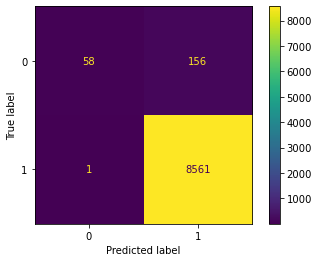

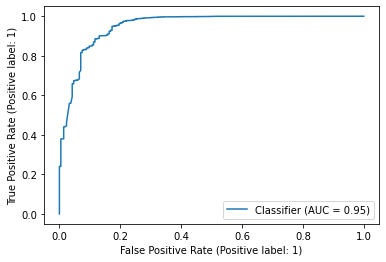

In [57]:
param_grid = {'max_depth': [2, 5, 10],
              'n_estimators': [5, 20, 50]}
RF_CV = GridSearchCV(RandomForestClassifier(n_jobs=1, random_state=42), param_grid, cv=3, scoring=make_scorer(roc_auc_score, needs_proba=True))
RF_CV.fit(train_data, train_classes)

pred = RF_CV.predict(test_data)
proba = RF_CV.predict_proba(test_data)
ConfusionMatrixDisplay.from_predictions(test_classes, pred)
RocCurveDisplay.from_predictions(test_classes, proba[:, 1])
print("Cross-Validated Random Forest AUC Score:", roc_auc_score(test_classes, proba[:, 1]))
print("Selected max depth:", RF_CV.best_params_['max_depth'])
print("Selected number of estimators:", RF_CV.best_params_['n_estimators'])

Unsurprisingly, the greatest value of each hyperparameter was chosen. We again see that the Random Forest performs similarly to its PySpark implementation, though this time it performs slightly worse. Increasing the values of these hyperparameters has produced a significant improvement on the AUC metric.

Finally, we do this with the gradient-boosted trees:

Cross-Validated Gradient-Boosted Trees AUC Score: 0.8447121272652255
Selected max depth: 5
Selected number of estimators: 20


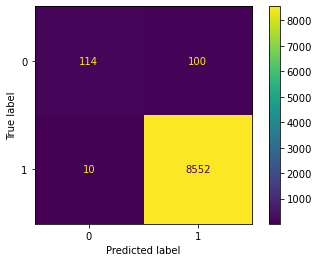

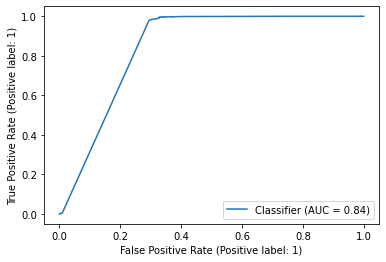

In [59]:
param_grid = {'max_depth': [2, 5, 10],
              'n_estimators': [5, 10, 20]}
GB_CV = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=3, scoring=make_scorer(roc_auc_score, needs_proba=True))
GB_CV.fit(train_data, train_classes)

pred = GB_CV.predict(test_data)
proba = GB_CV.predict_proba(test_data)
ConfusionMatrixDisplay.from_predictions(test_classes, pred)
RocCurveDisplay.from_predictions(test_classes, proba[:, 1])
print("Cross-Validated Gradient-Boosted Trees AUC Score:", roc_auc_score(test_classes, proba[:, 1]))
print("Selected max depth:", GB_CV.best_params_['max_depth'])
print("Selected number of estimators:", GB_CV.best_params_['n_estimators'])

Again we get a modest improvement by tuning the hyperparameters, though the performance is still worse than the PySpark implementation (in fact, the tuned scikit model had worse performance than the untuned pyspark model). 